# Effective Graph Paper
Code to generate "Leukemia" figure 

In [1]:
import os
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.2g}'.format
from IPython.display import Image, display
import graphviz
import cana
import math
from cana.boolean_network import BooleanNetwork
import matplotlib as mpl
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['mathtext.rm'] = 'serif'
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.text import Text
from matplotlib.patches import Circle, Rectangle, RegularPolygon
from matplotlib.collections import PatchCollection
from IPython.display import display, Image, Latex, SVG, HTML
import networkx as nx
from copy import copy
#
from cana.datasets.bio import LEUKEMIA
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler

In [2]:
def normalize(x, ab, db):
    return db[0] + (x - ab[0]) * (db[1] - db[0]) / (ab[1] - ab[0])

In [3]:
C = LEUKEMIA()

In [4]:
SG = C.structural_graph()
EG = C.effective_graph(mode='input', bound='mean')

In [5]:
# Rename some Nodes
SG.nodes[4]['label'] = EG.nodes[4]['label'] = 'Cytoskeleton\nsignaling'
#SG.nodes[26]['label'] = EG.nodes[26]['label'] = 'Prolif.'
#SG.nodes[40]['label'] = EG.nodes[40]['label'] = 'Cerami.'
#SG.nodes[42]['label'] = EG.nodes[42]['label'] = 'Caspa.'
#SG.nodes[49]['label'] = EG.nodes[49]['label'] = 'Apopto.'
SG.nodes[56]['label'] = EG.nodes[56]['label'] = 'Stimuli1'
SG.nodes[57]['label'] = EG.nodes[57]['label'] = 'Stimuli2'
for i,d in SG.nodes(data=True):
    print(i,d)

0 {'label': 'CTLA4'}
1 {'label': 'TCR'}
2 {'label': 'PDGFR'}
3 {'label': 'FYN'}
4 {'label': 'Cytoskeleton\nsignaling'}
5 {'label': 'LCK'}
6 {'label': 'ZAP70'}
7 {'label': 'GRB2'}
8 {'label': 'PLCG1'}
9 {'label': 'RAS'}
10 {'label': 'GAP'}
11 {'label': 'MEK'}
12 {'label': 'ERK'}
13 {'label': 'PI3K'}
14 {'label': 'NFKB'}
15 {'label': 'NFAT'}
16 {'label': 'RANTES'}
17 {'label': 'IL2'}
18 {'label': 'IL2RBT'}
19 {'label': 'IL2RB'}
20 {'label': 'IL2RAT'}
21 {'label': 'IL2RA'}
22 {'label': 'JAK'}
23 {'label': 'SOCS'}
24 {'label': 'STAT3'}
25 {'label': 'P27'}
26 {'label': 'Proliferation'}
27 {'label': 'TBET'}
28 {'label': 'CREB'}
29 {'label': 'IFNGT'}
30 {'label': 'IFNG'}
31 {'label': 'P2'}
32 {'label': 'GZMB'}
33 {'label': 'TPL2'}
34 {'label': 'TNF'}
35 {'label': 'TRADD'}
36 {'label': 'FasL'}
37 {'label': 'FasT'}
38 {'label': 'Fas'}
39 {'label': 'sFas'}
40 {'label': 'Ceramide'}
41 {'label': 'DISC'}
42 {'label': 'Caspase'}
43 {'label': 'FLIP'}
44 {'label': 'A20'}
45 {'label': 'BID'}
46 {'label

In [6]:
net_redundancy = 0
#
for nid, node in enumerate(C.nodes,start=0):
    net_redundancy += node.input_redundancy(mode='node', bound='upper', norm=False)
#
net_redundancy_norm = net_redundancy / C.Nnodes
#
print("Total Network Redundancy: {:.4} (norm: {:.4})".format(net_redundancy, net_redundancy_norm))

Total Network Redundancy: 71.88 (norm: 1.198)


In [7]:
dict_effconn = {nid: node.effective_connectivity(mode='node',bound='upper',norm=False) 
    for nid, node in enumerate(C.nodes,start=0) }
nx.set_node_attributes(EG, dict_effconn, 'effective_connectivity')

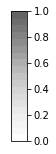

In [8]:
# ColorBar
interval = np.linspace(0.0, 0.70, 256)
colors = plt.cm.Greys(interval)
cmap = LinearSegmentedColormap.from_list('custom', colors)
#cmap = plt.get_cmap('Greys')
#cmap.set_under('white')
norm = mpl.colors.Normalize(vmin=0, vmax=1)

fig = plt.figure(figsize=(2,2))
ax = fig.add_axes([0.1, 0.05, 0.11, 0.9])
bounds = [0,0.2,0.4,0.6,0.8,1]
boundaries = np.linspace(0,1,20).tolist()

cb = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, boundaries=boundaries,
    extend='neither', extendfrac=.15, ticks=bounds, spacing='uniform', orientation='vertical')

In [9]:
# Node Positioning
nodes = {d['label']:i for i,d in SG.nodes(data=True)}
n = len(nodes)
nodes={v:k for k,v in nodes.items()}
att = {}

ctr_nodes = {i:d['label'] for i,d in SG.nodes(data=True) if i in [51,57,58,73,74,75,76,77,78,79]}
ALR = list(ctr_nodes.keys())
in1_nodes = {i:d['label'] for i,d in SG.nodes(data=True) if SG.out_degree(i)==2 and i not in ALR}
ALR.extend(list(in1_nodes.keys()))
in2_nodes = {i:d['label'] for i,d in SG.nodes(data=True) if SG.out_degree(i)==3 and i not in ALR}
ALR.extend(list(in2_nodes.keys()))
out_nodes = {i:d['label'] for i,d in SG.nodes(data=True) if i not in ALR}

n_in1 = len(in1_nodes)
n_in2 = len(in2_nodes)
n_out = len(out_nodes)
n_ctr = len(ctr_nodes)
r_ctr = 2
r_in1 = 3
r_in2 = 4
r_out = 5

ctr = max([r_in1,r_out,r_ctr])/2

for deg,(nid,label) in zip( np.linspace(0,360,n_in1,False), in1_nodes.items()):
    x, y = round(ctr + r_in1*math.cos(math.radians(deg)),2), round(ctr + r_in1*math.sin(math.radians(deg)),2)
    pos = '{:.2f},{:.2f}!'.format(x,y)
    att[nid] = {'label':label,'pos':pos,'fillcolor':'#515660'}
for deg,(nid,label) in zip( np.linspace(0,360,n_in2,False), in2_nodes.items()):
    x, y = round(ctr + r_in2*math.cos(math.radians(deg)),2), round(ctr + r_in2*math.sin(math.radians(deg)),2)
    pos = '{:.2f},{:.2f}!'.format(x,y)
    att[nid] = {'label':label,'pos':pos,'fillcolor':'#515660'}
for deg,(nid,label) in zip( np.linspace(0,360,n_out, False), out_nodes.items()):
    x, y = round(ctr + r_out*math.cos(math.radians(deg)),2), round(ctr + r_out*math.sin(math.radians(deg)),2)
    pos = '{:.2f},{:.2f}!'.format(x,y)
    att[nid] = {'label':label,'pos':pos,'fillcolor':'#515660'}
for deg,(nid,label) in zip( np.linspace(0,360,n_ctr,False), ctr_nodes.items()):
    x, y = round(ctr + r_ctr*math.cos(math.radians(deg)),2), round(ctr + r_ctr*math.sin(math.radians(deg)),2)
    pos = '{:.2f},{:.2f}!'.format(x,y)
    att[nid] = {'label':label,'pos':pos,'fillcolor':'red', 'width':'.99', 'shape':'oval'}

In [24]:
# Node Manual Positioning
idmap = {d['label']:i for i,d in SG.nodes(data=True)}
print( idmap)
att = {}
red = '#ff9896'
orange = '#ffbb78'
white = 'white'
blue = '#aec7e8'
green = '#98df8a'
# Line 10
att['S1P'] = {'pos':'2,10', 'shape': 'oval', 'fillcolor': red}
att['PDGF'] = {'pos':'3,10', 'shape': 'oval', 'fillcolor': red}
att['Ceramide'] = {'pos':'8,10', 'shape': 'oval', 'fillcolor': white, 'width':'.9'}
att['FasL'] = {'pos':'9,10', 'shape': 'oval', 'fillcolor': red}
att['sFas'] = {'pos':'10,10', 'shape': 'oval', 'fillcolor': red}
att['GZMB'] = {'pos':'11,10', 'shape': 'oval', 'fillcolor': white}
# Line 9
att['GPCR'] = {'pos':'1,9', 'shape': 'diamond', 'fillcolor': blue, 'width':'1'}
att['PDGFR'] = {'pos':'3,9', 'shape': 'diamond', 'fillcolor': red, 'width':'1'}
att['CTLA4'] = {'pos':'4,9', 'shape': 'box', 'fillcolor': white}
att['TCR'] = {'pos':'5,9', 'shape': 'diamond', 'fillcolor': white}
att['CD45'] = {'pos':'6,9', 'shape': 'box', 'fillcolor': blue}
att['Fas'] = {'pos':'8,9', 'shape': 'diamond', 'fillcolor': green}
#Line 8
att['LCK'] = {'pos':'6,8', 'shape': 'box', 'fillcolor': red}
#?att['Ceramide'] = {'pos':'8,10', 'shape': 'oval', 'fillcolor': 'white'}
att['DISC'] = {'pos':'10,8', 'shape': 'oval', 'fillcolor': white}
att['Caspase'] = {'pos':'12,8', 'shape': 'box', 'fillcolor': green, 'width':'0.9'}
att['Apoptosis'] = {'pos':'14,8', 'shape': 'polygon', 'fillcolor': orange, 'width':'1'}
# Line 7
#?att['S1P'] = {'pos':'2,0', 'shape': 'oval', 'fillcolor': red}
att['SPHK1'] = {'pos':'2,7', 'shape': 'box', 'fillcolor': red}
att['PLCG1'] = {'pos':'4,7', 'shape': 'box', 'fillcolor': white} # PLC
att['GRB2'] = {'pos':'5,7', 'shape': 'box', 'fillcolor': white}
att['ZAP70'] = {'pos':'6,7', 'shape': 'box', 'fillcolor': white}
att['FYN'] = {'pos':'7,7', 'shape': 'box', 'fillcolor': white}
att['CREB'] = {'pos':'8,7', 'shape': 'box', 'fillcolor': white}
att['FLIP'] = {'pos':'11,7', 'shape': 'box', 'fillcolor': red}
att['MCL1'] = {'pos':'12,7', 'shape': 'box', 'fillcolor': red}
att['BID'] = {'pos':'13,7', 'shape': 'box', 'fillcolor': white}
att['IAP'] = {'pos':'14,7', 'shape': 'box', 'fillcolor': white}
# Line 6
att['GAP'] = {'pos':'3,6', 'shape': 'box', 'fillcolor': white}
att['RAS'] = {'pos':'4.5,6', 'shape': 'box', 'fillcolor': red}
att['Cytoskeleton\nsignaling'] = {'pos':'6,6', 'shape': 'polygon', 'fillcolor': orange, 'width':'1.2'}
att['GZMB'] = {'pos':'8,6', 'shape': 'box', 'fillcolor': red}
att['FasT'] = {'pos':'11,6', 'shape': 'box', 'fillcolor': red}
att['BclxL'] = {'pos':'13,6', 'shape': 'box', 'fillcolor': green}
# Line 5
att['MEK'] = {'pos':'5,5', 'shape': 'box', 'fillcolor': red}
att['PI3K'] = {'pos':'6,5', 'shape': 'box', 'fillcolor': red}
att['Proliferation'] = {'pos':'9,5', 'shape': 'box', 'fillcolor': orange, 'width':'1'}
att['NFKB'] = {'pos':'13,5', 'shape': 'box', 'fillcolor': green}
att['TRADD'] = {'pos':'15,5', 'shape': 'box', 'fillcolor': white}
# Line 4
att['ERK'] = {'pos':'5,4', 'shape': 'box', 'fillcolor': red}
att['NFAT'] = {'pos':'6,4', 'shape': 'box', 'fillcolor': white}
att['TBET'] = {'pos':'8,4', 'shape': 'box', 'fillcolor': white}
att['P27'] = {'pos':'9,4', 'shape': 'box', 'fillcolor': white}
att['STAT3'] = {'pos':'10,4', 'shape': 'box', 'fillcolor': red}
att['IL2RAT'] = {'pos':'12,4', 'shape': 'box', 'fillcolor': green}
att['A20'] = {'pos':'14,4', 'shape': 'box', 'fillcolor': red}
# Line 3
att['SMAD'] = {'pos':'1,3', 'shape': 'box', 'fillcolor': white}
att['IL2RBT'] = {'pos':'4,3', 'shape': 'box', 'fillcolor': red}
att['IFNGT'] = {'pos':'5,3', 'shape': 'box', 'fillcolor': red}
att['JAK'] = {'pos':'8,3', 'shape': 'box', 'fillcolor': red}
att['SOCS'] = {'pos':'9,3', 'shape': 'box', 'fillcolor': white}
att['TPL2'] = {'pos':'13,3', 'shape': 'box', 'fillcolor': red}
att['TAX'] = {'pos':'14,3', 'shape': 'box', 'fillcolor': white}
# Line 2
att['IL2RB'] = {'pos':'7,2', 'shape': 'diamond', 'fillcolor': red}
att['IL2RA'] = {'pos':'13,2', 'shape': 'diamond', 'fillcolor': green}
att['Stimuli2'] = {'pos':'15,2', 'shape': 'polygon', 'fillcolor': orange, 'width': '0.9'}
# Line 1
att['Stimuli1'] = {'pos':'3,1', 'shape': 'polygon', 'fillcolor': orange, 'width': '0.9'}
att['IFNG'] = {'pos':'5,1', 'shape': 'box', 'fillcolor': blue}
att['IL15'] = {'pos':'7,1', 'shape': 'oval', 'fillcolor': red}
att['IL2'] = {'pos':'9,1.5', 'shape': 'oval', 'fillcolor': red}
att['RANTES'] = {'pos':'11,1.5', 'shape': 'oval', 'fillcolor': red, 'width':'0.7'}
att['TNF'] = {'pos':'14,1', 'shape': 'box', 'fillcolor': white}
att['P2'] = {'pos':'14,1', 'shape': 'box', 'fillcolor': white}

# Inverse Map
att = {idmap[k]:v for k,v in att.items()}

{'CTLA4': 0, 'TCR': 1, 'PDGFR': 2, 'FYN': 3, 'Cytoskeleton\nsignaling': 4, 'LCK': 5, 'ZAP70': 6, 'GRB2': 7, 'PLCG1': 8, 'RAS': 9, 'GAP': 10, 'MEK': 11, 'ERK': 12, 'PI3K': 13, 'NFKB': 14, 'NFAT': 15, 'RANTES': 16, 'IL2': 17, 'IL2RBT': 18, 'IL2RB': 19, 'IL2RAT': 20, 'IL2RA': 21, 'JAK': 22, 'SOCS': 23, 'STAT3': 24, 'P27': 25, 'Proliferation': 26, 'TBET': 27, 'CREB': 28, 'IFNGT': 29, 'IFNG': 30, 'P2': 31, 'GZMB': 32, 'TPL2': 33, 'TNF': 34, 'TRADD': 35, 'FasL': 36, 'FasT': 37, 'Fas': 38, 'sFas': 39, 'Ceramide': 40, 'DISC': 41, 'Caspase': 42, 'FLIP': 43, 'A20': 44, 'BID': 45, 'IAP': 46, 'BclxL': 47, 'MCL1': 48, 'Apoptosis': 49, 'GPCR': 50, 'SMAD': 51, 'SPHK1': 52, 'S1P': 53, 'PDGF': 54, 'IL15': 55, 'Stimuli1': 56, 'Stimuli2': 57, 'CD45': 58, 'TAX': 59}


## Structural Graph

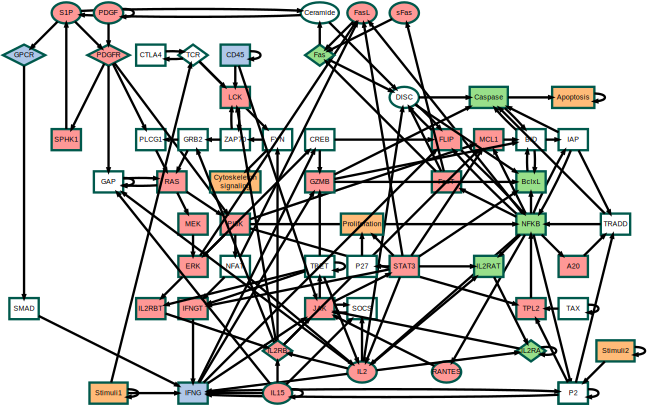

Format: "pdf" not recognized. Use one of: canon cmap cmapx cmapx_np dot dot_json eps fig gv imap imap_np ismap json json0 mp pic plain plain-ext pov ps ps2 svg svgz tk vml vmlz xdot xdot1.2 xdot1.4 xdot_json


CalledProcessError: Command '['neato', '-Tpdf', '-O', '/Users/rionbr/Sites/CANA/tutorials/2019 - Effective Graph/Figure-cancer/Cancer-SG']' returned non-zero exit status 1.

In [53]:
pSG = graphviz.Digraph(name='Structural Graph', engine='neato')
pSG.attr('graph', size='9,9', concentrate='false', simplify='false', overlap='true',splines='false',ratio='auto')
pSG.attr('node', pin='true', shape='circle', fixedsize='true', color='#00594c', style='filled', fillcolor='#515660', penwidth='4', fontname='Helvetica', fontcolor='black',fontsize='12')
pSG.attr('edge', arrowhead='normal', arrowsize='.5', color='black', penwidth='4')

for nid,SGatt in SG.nodes(data=True):
    label = SGatt['label']
    if nid in att:
        pos = att[nid].get('pos', '')
        shape = att[nid].get('shape', '')
        fillcolor = att[nid].get('fillcolor', '')
        width = att[nid].get('width', '.70')
        pSG.node(str(nid), label=label, pos=pos, shape=shape, fillcolor=fillcolor, width=width)

max_penwidth = 4
for uid,vid,d in SG.edges(data=True):
    uid = str(uid)
    vid = str(vid)
    weight = '%d' % (d['weight']*100)
    pSG.edge(uid, vid, weight=weight)
    
display(SVG(pSG.pipe(format='svg')),metadata={'isolated':True})
# Export
pSG._format = 'pdf'
efile = u"{path:s}/Figure-leukemia/Leukemia-SG".format(path=os.getcwd())
pSG.render(efile, cleanup=True)

## Effective Graph

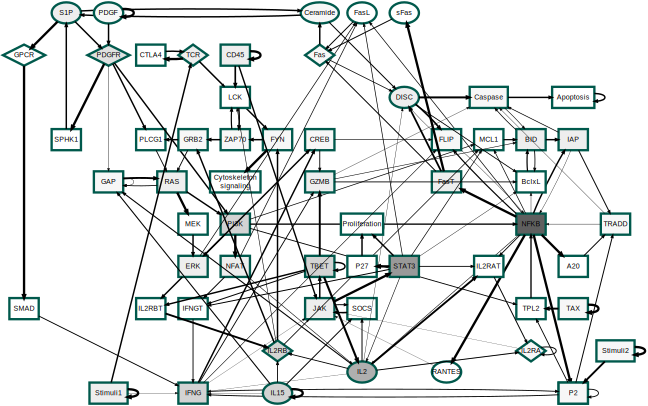

'/Users/rionbr/Sites/CANA/tutorials/2019 - Effective Graph/Figure-cancer/Cancer-EG.svg'

In [50]:
pEG = graphviz.Digraph(name='Structural Graph', engine='neato')
pEG.attr('graph', size='9,9', concentrate='false', simplify='false', overlap='true',splines='false',ratio='auto')
pEG.attr('node', pin='true', shape='circle', fixedsize='true', color='#00594c', style='filled', fillcolor='#515660', penwidth='4', fontname='Helvetica', fontcolor='black',fontsize='12')
pEG.attr('edge', arrowhead='normal', arrowsize='.5', color='black', penwidth='4')

max_effoutdegree = max([v for n,v in EG.out_degree()])
list_effconn = [d['effective_connectivity'] for n,d in EG.nodes(data=True)]
min_effconn, max_effconn = min(list_effconn), max(list_effconn)
#
norm = mpl.colors.Normalize(vmin=1, vmax=max_effoutdegree)
for nid,d in EG.nodes(data=True):
    label = d['label']
    pos = att[nid].get('pos', '')
    #width = '{:.2f}'.format( normalize(d['effective_connectivity'], (min_effconn,max_effconn),(0.50,0.80) ) )
    #att[nid]['width'] = width
    shape = att[nid].get('shape')
    width = att[nid].get('width','.70')
    # fillcolor
    rgb = cmap(norm(EG.out_degree(nid)))
    hex = mpl.colors.rgb2hex(rgb)
    #att[nid]['fillcolor'] = hex
    pEG.node(str(nid), label=label, pos=pos, shape=shape, fillcolor=hex, width=width)

max_penwidth = 4
for uid,vid,d in EG.edges(data=True):
    uid = str(uid)
    vid = str(vid)
    weight = '%d' % (d['weight']*100)
    penwidth = '%.2f' % ( d['weight']*max_penwidth )
    if d['weight'] > 0:
        rgb = cmap(d['weight'])
        hex = mpl.colors.rgb2hex(rgb)
        pEG.edge(uid,vid, weight=weight, penwidth=penwidth)
    else:
        pEG.edge(uid,vid, style='dashed', color='#A90533')
    
display(SVG(pEG.pipe(format='svg')),metadata={'isolated':True})
# Export
pEG._format = 'svg'
efile = u"{path:s}/Figure-leukemia/Leukemia-EG".format(path=os.getcwd())
pEG.render(efile, cleanup=True)

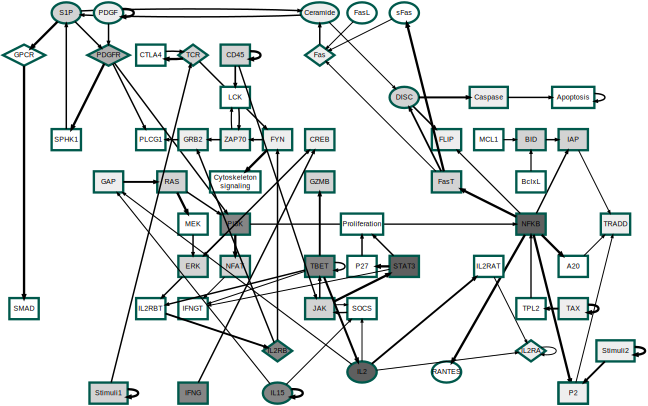

'/Users/rionbr/Sites/CANA/tutorials/2019 - Effective Graph/Figure-cancer/Cancer-EG-t0-4.svg'

In [52]:
EGt1 = EG.copy()
threshold = 0.40
EGt1.remove_edges_from( [(u,v) for u,v,d in EGt1.edges(data=True) if d['weight']<threshold] )

pEGt1 = graphviz.Digraph(name='Structural Graph', engine='neato')
pEGt1.attr('graph', size='9,9', concentrate='false', simplify='false', overlap='true',splines='false',ratio='auto')
pEGt1.attr('node', pin='true', shape='circle', fixedsize='true', color='#00594c', style='filled', fillcolor='#515660', penwidth='4', fontname='Helvetica', fontcolor='black',fontsize='12')
pEGt1.attr('edge', arrowhead='normal', arrowsize='.5', color='black', penwidth='4')

max_effoutdegree = max([v for n,v in EGt1.out_degree()])
list_effconn = [d['effective_connectivity'] for n,d in EGt1.nodes(data=True)]
min_effconn, max_effconn = min(list_effconn), max(list_effconn)
#
norm = mpl.colors.Normalize(vmin=1, vmax=max_effoutdegree)
for nid,d in EGt1.nodes(data=True):
    label = d['label']
    pos = att[nid].get('pos','')
    shape = att[nid].get('shape')
    width = att[nid].get('width','.70')
    # fillcolor
    rgb = cmap(norm(EG.out_degree(nid)))
    hex = mpl.colors.rgb2hex(rgb)
    pEGt1.node(str(nid), label=label, pos=pos, shape=shape, fillcolor=hex, width=width)

max_penwidth = 4
for uid,vid,d in EGt1.edges(data=True):
    uid = str(uid)
    vid = str(vid)
    weight = '%d' % (d['weight']*100)
    penwidth = '%.2f' % ( d['weight']*max_penwidth )
    rgb = cmap(d['weight'])
    hex = mpl.colors.rgb2hex(rgb)
    pEGt1.edge(uid,vid, weight=weight, penwidth=penwidth, color='black')
    
display(SVG(pEGt1.pipe(format='svg')),metadata={'isolated':True})
# Export
pEGt1._format = 'svg'
efile = u"{path:s}/Figure-leukemia/Leukemia-EG-t{t:s}".format(path=os.getcwd(), t=str(threshold).replace('.','-') )
pEGt1.render(efile, cleanup=True)